In [1]:
import os
import pandas as pd
import numpy as np
import chembl_webresource_client
from chembl_webresource_client.new_client import new_client
from molvs import standardize_smiles
from rdkit import Chem
from rdkit.Chem import PandasTools, QED, Descriptors, rdMolDescriptors

In [1]:
def chembl_bioactivity_mining(chembl_id):
    compounds_api = new_client.molecule
    bioactivities_api = new_client.activity
    # Get bioactivity data
    df = pd.DataFrame.from_records(bioactivities_api.filter(
        target_chembl_id=chembl_id).only(
        'molecule_chembl_id', #yes
        'molecule_structures', #yes
        'type', #yes
        'relation', #yes
        'values', #yes
        'units', #yes
        'assay_description', #yes
        'assay_chembl_id', #yes
        'bao_label', #yes
        'target_organism', #yes
        'target_chembl_id', #yes
        'document_chembl_id' #yes
             ))
    return df

def chembl_mol_mining(df):
    # Get corresponding SMILES
    id_list = list(df['molecule_chembl_id'].value_counts().index)
    df_smiles = pd.DataFrame.from_records(compounds_api.filter(
              molecule_chembl_id__in=id_list).only(
                  'molecule_chembl_id',
                 'molecule_structures'
             ))
    # Maybe some molecule cannot find SMILES, we iterally search the ChEMBL ID
    # to filter the missing molecules.
    try:
        df_smiles['molecule_structures'] = df_smiles['molecule_structures'].map(
            lambda x: x['canonical_smiles'])
    except:
        for idx, i in enumerate(id_list):
            if idx == 0:
                df_smiles = pd.DataFrame.from_records(compounds_api.filter(
                          molecule_chembl_id__in=[i]).only(
                              'molecule_chembl_id',
                             'molecule_structures'
                         ))
            else:
                try:
                    df_smiles = pd.concat([
                        df_smiles, pd.DataFrame.from_records(compounds_api.filter(
                          molecule_chembl_id__in=[i]).only(
                              'molecule_chembl_id',
                             'molecule_structures'
                         ))])
                except:
                    print(i)
                    pass
        id_smiles = {}
        for i in df_smiles.values:
            idx = i[0]
            smiles = i[1]
            try:
                id_smiles[idx] = smiles['canonical_smiles']
            except:
                id_smiles[idx] = None
        df_smiles = pd.DataFrame(np.array([list(id_smiles.keys()),
                                           list(id_smiles.values())]).T,
                                 columns=['molecule_chembl_id', 'molecule_structures'])  
    return df_smiles

def chembl_assemble(df, df_smiles):
    # Assemble them
    smiles = dict(zip(df_smiles['molecule_chembl_id'].values, df_smiles['molecule_structures'].values))
    df['SMILES'] = df['molecule_chembl_id'].map(lambda x: smiles[x] 
                                                if x in smiles.keys() else None)
    df.columns = ['Assay ChEMBL ID', 'Assay Description', 'BAO Label',
                  'Document ChEMBL ID', 'Molecule ChEMBL ID', 'Standard Relation',
                  'Target ChEMBL ID', 'Target Organism', 'Standard Type',
                  'Standard Units', 'Standard Value', 'SMILES']
    df = df[['Molecule ChEMBL ID', 'Standard Type', 'Standard Relation', 
             'Standard Value', 'Standard Units', 'SMILES', 'Assay ChEMBL ID', 
             'Assay Description', 'BAO Label', 'Target ChEMBL ID',
             'Target Organism', 'Document ChEMBL ID']]
    return df

def standardization(data):
    try:
        return standardize_smiles(data)
    except:
        print('SMILE {} error'.format(data))
        return None

chembl_id = 'CHEMBL2366634'
df = chembl_bioactivity_mining(chembl_id)
df_smiles = chembl_mol_mining(df)
df = chembl_assemble(df, df_smiles)
df.to_csv(f'{chembl_id}.csv', index=None)

In [2]:
df1 = pd.read_csv('CHEMBL360.csv')
print(len(df1))
df2 = pd.read_csv('CHEMBL2111188.csv')
print(len(df2))
df3 = pd.read_csv('CHEMBL2366634.csv')
print(len(df3))
df = pd.concat([df1, df2, df3])
print(len(df))
df = df[df['Standard Relation'] == '=']
print(len(df))
df

168749
23554
2022
194325
176256


,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,SMILES,Assay ChEMBL ID,Assay Description,BAO Label,Target ChEMBL ID,Target Organism,Document ChEMBL ID
2,CHEMBL991,Inhibition,=,0.00000,%,Cc1cn([C@H]2C=C[C@@H](CO)O2)c(=O)[nH]c1=O,CHEMBL752463,Antimycobacterial activity against Mycobacteri...,organism-based format,CHEMBL360,Mycobacterium tuberculosis,CHEMBL1138695
3,CHEMBL124267,pMIC,=,1.92000,NaN,NNC(=O)c1ccc(O)cc1,CHEMBL749419,Minimum inhibitory concentration against Mycob...,organism-based format,CHEMBL360,Mycobacterium tuberculosis,CHEMBL1148365
4,CHEMBL124267,MIC,=,12.00000,ug ml-1,NNC(=O)c1ccc(O)cc1,CHEMBL3096848,Antitubercular activity against Mycobacterium ...,organism-based format,CHEMBL360,Mycobacterium tuberculosis,CHEMBL3091347
5,CHEMBL124267,log(1/MIC),=,-1.07918,NaN,NNC(=O)c1ccc(O)cc1,CHEMBL3096848,Antitubercular activity against Mycobacterium ...,organism-based format,CHEMBL360,Mycobacterium tuberculosis,CHEMBL3091347
6,CHEMBL341477,pMIC,=,1.82000,NaN,NNC(=O)c1cscn1,CHEMBL749419,Minimum inhibitory concentration against Mycob...,organism-based format,CHEMBL360,Mycobacterium tuberculosis,CHEMBL1148365
...,...,...,...,...,...,...,...,...,...,...,...,...
2017,CHEMBL4299626,MIC,=,10.33000,uM,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)C(=O)NC1(C(=O)N...,CHEMBL3825486,Antibacterial activity against Mycobacterium t...,organism-based format,CHEMBL2366634,Mycobacterium tuberculosis H37Ra,CHEMBL3822432
2018,CHEMBL4299632,MIC,=,20.92000,uM,CC(=O)NCC(=O)N[C@H](Cc1ccccc1)C(=O)NC1(C(=O)NC...,CHEMBL3825486,Antibacterial activity against Mycobacterium t...,organism-based format,CHEMBL2366634,Mycobacterium tuberculosis H37Ra,CHEMBL3822432
2019,CHEMBL3822471,MIC,=,22.42000,uM,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)C(=O)NC1(C(=O)N...,CHEMBL3825486,Antibacterial activity against Mycobacterium t...,organism-based format,CHEMBL2366634,Mycobacterium tuberculosis H37Ra,CHEMBL3822432
2020,CHEMBL3822476,MIC,=,21.87000,uM,CC(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[...,CHEMBL3825486,Antibacterial activity against Mycobacterium t...,organism-based format,CHEMBL2366634,Mycobacterium tuberculosis H37Ra,CHEMBL3822432


In [6]:
df_percent = df[df['Standard Type'] == 'Percent Effect']
df_mic = df[df['Standard Type'] == 'MIC']

In [ ]:
df_mic['Standard Units'] = df_mic['Standard Units'].map(lambda x: 'uM' 
                                    if x in ['uM', 'umol/L', 'uM/L', 'microM', 
                                             'uM l-1', "10'-6 mol/L"] else x)
df_mic['SMILES'] = df_mic['SMILES'].map(standardization)

In [8]:
print(len(df_mic))
df_mic = df_mic.dropna(subset=['SMILES'])
print(len(df_mic))
df_mic['MW'] = df_mic['SMILES'].map(lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))
df_mic['LogP'] = df_mic['SMILES'].map(lambda x: Descriptors.MolLogP(Chem.MolFromSmiles(x)))

30982
30982


In [10]:
df_mic.loc[df_mic['Standard Units'] == 'ug ml-1', 
           'Standard Value'] = (df_mic[df_mic['Standard Units'] == 'ug ml-1'
                                     ]['Standard Value'] / df_mic[df_mic['Standard Units'] == 'ug ml-1'
                                     ]['MW']) * 1000
df_mic.loc[df_mic['Standard Units'] == 'ug ml-1', 
           'Standard Value'].describe()
df_mic = df_mic[df_mic['Standard Units'].isin(['uM', 'ug ml-1'])]
df_mic['Standard Units'] = 'uM'
df_mic['Standard Value'] /= 10**3
df_mic['Standard Value'] = - np.log10(df_mic['Standard Value'])

D:\anaconda3-64bit\envs\my-rdkit-env\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
df_mic = df_mic[~np.isinf(df_mic['Standard Value'])]
df_mic['Standard Value'].describe()

count    30305.000000
mean         5.151661
std          1.013635
min          1.778981
25%          4.420808
50%          5.036212
75%          5.836140
max         10.000000
Name: Standard Value, dtype: float64

<AxesSubplot:ylabel='Frequency'>

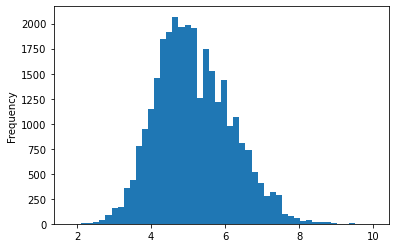

In [31]:
df_mic['Standard Value'].plot(kind='hist', bins=50)

In [222]:
df_mic_ = df_mic[df_mic['Standard Units'].isin(['uM', 'ug ml-1'])]
df_mic_['Standard Units'] = 'uM'
df_mic_['Standard Value'] /= 10**6
df_mic_['Standard Value'] = - np.log10(df_mic_['Standard Value'])

D:\anaconda3-64bit\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\anaconda3-64bit\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda3-64bit\envs\my-rdkit-env\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **

In [237]:
df_mic_['Label_reg'] = df_mic_['Standard Value']
df_mic_['Label_clf'] = df_mic_['Standard Value'].map(lambda x: 1 if x >= 6 else 0)
df_mic_.to_csv('MIC.csv', index=None)

D:\anaconda3-64bit\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\anaconda3-64bit\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
print(len(df_mic))
df_mic = df_mic.dropna(subset=['SMILES'])
print(len(df_mic))
df_mic['MW'] = df_mic['SMILES'].map(lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))
df_mic['LogP'] = df_mic['SMILES'].map(lambda x: Descriptors.MolLogP(Chem.MolFromSmiles(x)))